# Note on DFT geometry optimization
```from SMILES to ORCA input and visualization```

## Part 1 from SMILES to orca.inp

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

header = f"""! Opt r2SCAN-3c noautostart miniprint nopop PrintGap
%elprop
   Polar 1
end
%maxcore 3000
%pal
   nprocs 16
end
* xyz 0 1"""

def get_canonical_smiles(smiles_string):
    """
    Converts a given SMILES string to its canonical SMILES representation.
    """
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is not None:
        return Chem.MolToSmiles(mol, canonical=True)
    else:
        return None
        
def smiles2xyz(smiles_str):
    mol = Chem.MolFromSmiles(smiles_str)
    # Add hydrogen
    mol = Chem.AddHs(mol) 
    # Generates 3D coordinates using the ETKDGv3 algorithm
    AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
    # Optimizes the geometry using the MMFF force field
    AllChem.MMFFOptimizeMolecule(mol) 
    xyz_str = Chem.MolToXYZBlock(mol)
    return xyz_str

def xyz2orca(xyz_str):
    """
    Convert xyz format string to orca input
    """
    # keep string from line 3
    coord_str = xyz_str.strip().split('\n')[2:]
    
    orca_input = f"""{header}{'\n'}{'\n'.join(coord_str)}"""

    return orca_input    

def gen_orca(smiles_str):
    """
    Generate the final orca.inp with canonical SMILES as a comment line.
    """
    xyz_str = smiles2xyz(smiles_str)
    orca_input = xyz2orca(xyz_str)
    
    smiles_c = get_canonical_smiles(smiles_str)
    
    # add smiles code as the 1st line
    # add input content from the 2nd line
    # add * to the end
    orca_str = f"""{'# ' + smiles_c +'\n'}{orca_input}{'\n*'}"""
    return orca_str, xyz_str

def write_fn(smiles_str, orca_fname, xyz_fname):
    """
    Convert smiles to xyz file and orca input file with given names, respectively.
    """
    _orca, _xyz = gen_orca(smiles_str)

    with open(orca_fname, 'w') as f:
        f.write(_orca)
    with open(xyz_fname, 'w') as f:
        f.write(_xyz)
        
    #print('Done! Saved as ' + output_name)

In [2]:
smiles = 'CCCC1=CC=C(C=C1)C#CC1=CC(F)=CC(F)=C1'
write_fn(smiles, 'test.inp', 'test.xyz')

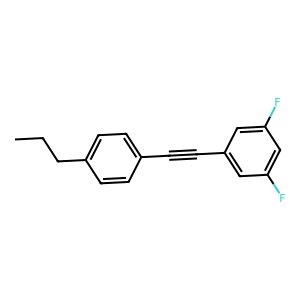

In [3]:
mol = Chem.MolFromSmiles(smiles)
Chem.Draw.MolToImage(mol)

## Part 2: Visualize XYZ file with index number as atom label

In [4]:
from rdkit import Chem
import rdkit.Chem.rdDetermineBonds as rDB
import py3Dmol

def xyz_view(xyz_file):
    # read xyz file (dots only)
    mol = Chem.MolFromXYZFile(xyz_file)
    # determine bond connections
    rDB.DetermineBonds(mol)
    
    view = py3Dmol.view(width=800, height=400)
    view.addModel(Chem.MolToMolBlock(mol), 'mol')
    
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        pos = mol.GetConformer().GetAtomPosition(idx)
        
        view.addLabel(
            str(idx+1),  # The label text (atom index)
            {
                'position': {'x': pos.x, 'y': pos.y, 'z': pos.z},
                'backgroundColor': 'black',
                'fontColor': 'white',
                'fontSize': 13,
                'showBackground': True,
                'fontOpacity': 1
            }
        )
    
    view.setStyle({'stick': {}, 'sphere': {'scale': 0.3}}) # Customize visualization style
    view.zoomTo()
    view.show()

In [5]:
xyz_view('test.xyz')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.